### Introduction

In this notebook, I'm trying to integrate the public notebook for Ventillator Pressure Competition written in Pytorch to Fastai. The reason is to leverage high level API of fastai to avoid repetitive pattern ( for example fititing with a scheduler learning rate, adding some callback  like ReduceLROnPlateau )


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
!pip install -Uqq fastai

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.callback.progress import ProgressCallback
from fastai.optimizer import OptimWrapper
from torch import optim
from fastai.losses import MSELossFlat, L1LossFlat
from fastai.callback.schedule import Learner
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import IndexSplitter
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import KFold
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    print('Number of device:', torch.cuda.device_count())
    return device
DEVICE = get_device()

Using device: cuda
Number of device: 1


In [4]:
train = pd.read_csv('../../data/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../../data/ventilator-pressure-prediction/test.csv')
df_test = pd.read_csv("../../data/ventilator-pressure-prediction/sample_submission.csv")

In [4]:
# max_size = 100

In [5]:
# df = df[df.breath_id < max_size]

In [6]:
def add_features(df):
    df["step"] = list(range(80)) * (df.shape[0] // 80)

    # u_out
    print("--- Generate u_out features ---")
    df['u_out_diff'] = df.groupby("breath_id")['u_out'].diff().fillna(0)
    for shift in range(1, 3):
        df[f'u_out_diff_back{shift}'] = df.groupby('breath_id')['u_out_diff'].shift(-shift)
    df.fillna(0, inplace=True)

    # time
    print("--- Generate time features ---")
    df['cross_time'] = df['time_step'] * (1 - df['u_out'])
    df['time_delta'] = df.groupby("breath_id")['time_step'].diff().fillna(0.033098770961621796)

    # u_in
    print("--- Generate u_in features ---")
    g = df.groupby('breath_id')['u_in']
    df['cross_u_in'] = df['u_in'] * (1 - df['u_out'])
    # shift
    for shift in range(1, 5):
        df[f'u_in_lag{shift}'] = g.shift(shift)
        df[f'u_in_lag_back{shift}'] = g.shift(-shift)
        df[f'u_in_diff{shift}'] = df["u_in"] - df[f'u_in_lag{shift}']
        df[f'u_in_diff_back{shift}'] = df["u_in"] - df[f'u_in_lag_back{shift}']
    df.fillna(0, inplace=True)
    # cumsum
    df['u_in_cumsum'] = g.cumsum()
    df['tmp'] = df['time_delta'] * df['u_in']
    df['area'] = df.groupby('breath_id')['tmp'].cumsum()
    df.drop(columns=["tmp"], inplace=True)
    # expanding
    df['ewm_u_in_mean'] = g.ewm(halflife=10).mean().reset_index(level=0, drop=True)
    # rolling
    df['rolling_10_mean'] = g.rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_10_max'] = g.rolling(window=10, min_periods=1).max().reset_index(level=0, drop=True)
    # expanding
    df['expand_mean'] = g.expanding(1).mean().reset_index(level=0, drop=True)
    df['expand_median'] = g.expanding(1).median().reset_index(level=0, drop=True)
    df['expand_std'] = g.expanding(5).std().reset_index(level=0, drop=True).fillna(0)
    df['expand_max'] = g.expanding(1).max().reset_index(level=0, drop=True)
    # transform
    df['u_in_max'] = g.transform('max')
    df['u_in_mean'] = g.transform('mean')
    df['u_in_diffmax'] = df['u_in_max'] - df['u_in']
    df['u_in_diffmean'] = df['u_in_mean'] - df['u_in']

    # rate
    df['u_in_rate'] = df['u_in_diff1'] / df['time_delta']

    # R C
    print("--- Generate R C features ---")
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R_C'] = df["R"] + '_' + df["C"]
    df = pd.get_dummies(df)

    df = df.fillna(0)
    df.sort_values("id", inplace=True)
    return df


train = add_features(train)
test = add_features(test)

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate R C features ---
--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate R C features ---


In [7]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure','id', 'breath_id'], axis=1, inplace=True)
test.drop(['id', 'breath_id'], axis=1, inplace=True)

In [8]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [9]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [10]:
idx = list(range(len(train)))

In [11]:
# train_input, valid_input = train[:3000], train[3000:4000]
# train_targets, valid_targets = targets[:3000], targets[3000:4000]

In [12]:
train.shape[-2:]

(80, 55)

In [13]:
class VentilatorDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).float()
        if target is not None:
            self.targets = torch.from_numpy(target).float()
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if hasattr(self, 'targets'): return self.data[idx], self.targets[idx]
        else: return self.data[idx]

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size=25):
        hidden = [400, 300, 200, 100]
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)

        return x

In [15]:
# next(model.parameters())

In [16]:
batch_size = 512
submission = pd.read_csv('../../data/ventilator-pressure-prediction/sample_submission.csv')
test_dataset = VentilatorDataset(test, None)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [18]:
########################## Experimenting with one fold

In [26]:
train_index=list(range(int(0.95*len(train)))) ## Change to have reasonable train/valid dataset
valid_index=list(range(int(0.05*len(train)), len(train)))
len(train_index), len(valid_index)

(71677, 71678)

In [27]:
train_input, valid_input = train[train_index], train[valid_index]
train_targets, valid_targets = targets[train_index], targets[valid_index]

train_dataset = VentilatorDataset(train_input, train_targets)
valid_dataset = VentilatorDataset(valid_input, valid_targets)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)

dls = DataLoaders(train_loader, valid_loader)
model = RNNModel(train.shape[-1])


SuggestedLRs(valley=0.0004786300996784121)

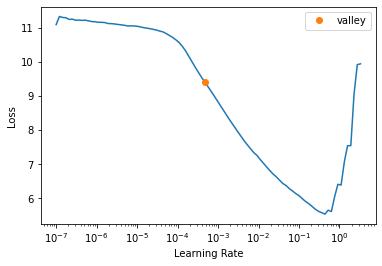

In [28]:
learn = Learner(dls, model, loss_func=L1LossFlat())
learn.lr_find()

In [29]:
learn.fit_one_cycle(235, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))
preds = []
with torch.no_grad():
    for data in test_loader:
        pred = model(data.to('cuda')).squeeze(-1).flatten()
        preds.extend(pred.detach().cpu().numpy())
# preds_fold.append(preds)
df_test['pressure'] = preds
df_test[['id', 'pressure']].to_csv('submission.csv', index=False)

epoch,train_loss,valid_loss,time
0,3.027942,2.195580,00:31
1,1.360443,1.076597,00:31
2,0.946532,0.882569,00:31
3,0.796319,0.755836,00:31
4,0.718133,0.669162,00:31
5,0.619426,0.599135,00:31
6,0.563846,0.556323,00:31
7,0.529916,0.542827,00:31
8,0.493984,0.486890,00:31
9,0.483141,0.458474,00:31


Epoch 16: reducing lr to 4.498000780989165e-05
Epoch 26: reducing lr to 9.180432623914618e-05
Epoch 36: reducing lr to 0.0001420336386335746
Epoch 46: reducing lr to 0.00018164407280730138
Epoch 56: reducing lr to 0.00019957653213829228
Epoch 66: reducing lr to 0.00019892258894513873
Epoch 76: reducing lr to 0.0001947596203064504
Epoch 86: reducing lr to 0.0001875939658459577
Epoch 96: reducing lr to 0.00017765268727292115
Epoch 106: reducing lr to 0.00016525079491790166
Epoch 116: reducing lr to 0.00015078129378179601
Epoch 126: reducing lr to 0.00013470267182389106
Epoch 136: reducing lr to 0.00011752444085933489
Epoch 146: reducing lr to 9.979092253780081e-05
Epoch 156: reducing lr to 8.20640795217949e-05
Epoch 166: reducing lr to 6.490559859951664e-05
Epoch 176: reducing lr to 4.885921230965487e-05
Epoch 186: reducing lr to 3.4433408816921275e-05
Epoch 196: reducing lr to 2.208526754367585e-05
Epoch 206: reducing lr to 1.220611538504412e-05
Epoch 216: reducing lr to 5.1089863986156

In [ ]:
########################################################################## Uncomment code below KFold Prediction

In [ ]:
# kf = KFold(n_splits=5, shuffle=True)
# preds_fold = []
        
# for fold, (train_index, valid_index) in enumerate(kf.split(idx)):
#     preds = []
#     model = RNNModel().to('cuda')
#     print("FOLD:", fold)
#     print(train_index)
#     print(valid_index)

#     train_input, valid_input = train[train_index], train[valid_index]
#     train_targets, valid_targets = targets[train_index], targets[valid_index]

#     train_dataset = VentilatorDataset(train_input, train_targets)
#     valid_dataset = VentilatorDataset(valid_input, valid_targets)
    
#     train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
#     valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)
    
#     dls = DataLoaders(train_loader, valid_loader)
#     learn = Learner(dls, model, loss_func=MSELossFlat())
#     learn.fit_one_cycle(1, lr_max=2e-3)
    
#     with torch.no_grad():
#         for data in test_loader:
#             pred = model(data.to('cuda')).squeeze(-1).flatten()
#             preds.extend(pred.detach().cpu().numpy())
#     preds_fold.append(preds)

In [ ]:
# preds_fold = np.array(preds_fold)
# df_test['pressure'] = np.median(preds_fold, axis=0)
# df_test[['id', 'pressure']].to_csv('submission.csv', index=False)